# Introduction to Artificial Neural Networks with Keras

## Setup

This project requires Python 3.7 or above:

In [1]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

And TensorFlow ≥ 2.8:

In [3]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

2023-12-26 19:39:47.659011: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-26 19:39:48.088849: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-26 19:39:50.459396: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


As we did in previous chapters, let's define the default font sizes to make the figures prettier:

In [4]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/ann` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [5]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ann"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## From Biological to Artificial Neurons

### The Perceptron

In [6]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = (iris.target == 0)  # Iris setosa

per_clf = Perceptron(random_state=42)
per_clf.fit(X, y)

X_new = [[2, 0.5], [3, 1]]
y_pred = per_clf.predict(X_new)  # predicts True and False for these 2 flowers

In [7]:
y_pred

array([ True, False])

The `Perceptron` is equivalent to a `SGDClassifier` with `loss="perceptron"`, no regularization, and a constant learning rate equal to 1:

In [8]:
# extra code – shows how to build and train a Perceptron

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss="perceptron", penalty=None, learning_rate="constant", eta0=1, random_state=42)
sgd_clf.fit(X, y)
assert (sgd_clf.coef_ == per_clf.coef_).all()
assert (sgd_clf.intercept_ == per_clf.intercept_).all()

When the Perceptron finds a decision boundary that properly separates the classes, it stops learning. This means that the decision boundary is often quite close to one class:

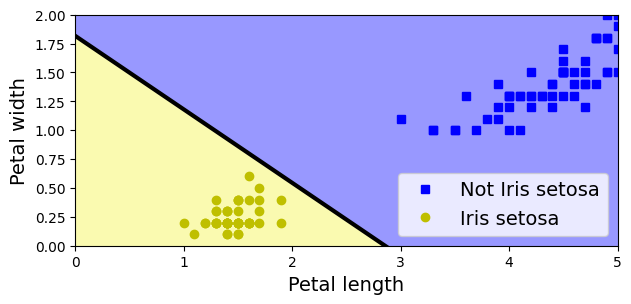

In [9]:
# extra code – plots the decision boundary of a Perceptron on the iris dataset

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

a = -per_clf.coef_[0, 0] / per_clf.coef_[0, 1]
b = -per_clf.intercept_ / per_clf.coef_[0, 1]
axes = [0, 5, 0, 2]
x0, x1 = np.meshgrid(
    np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
    np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
)
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.figure(figsize=(7, 3))
plt.plot(X[y == 0, 0], X[y == 0, 1], "bs", label="Not Iris setosa")
plt.plot(X[y == 1, 0], X[y == 1, 1], "yo", label="Iris setosa")
plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-",
         linewidth=3)
plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="lower right")
plt.axis(axes)
plt.show()

**Activation functions**

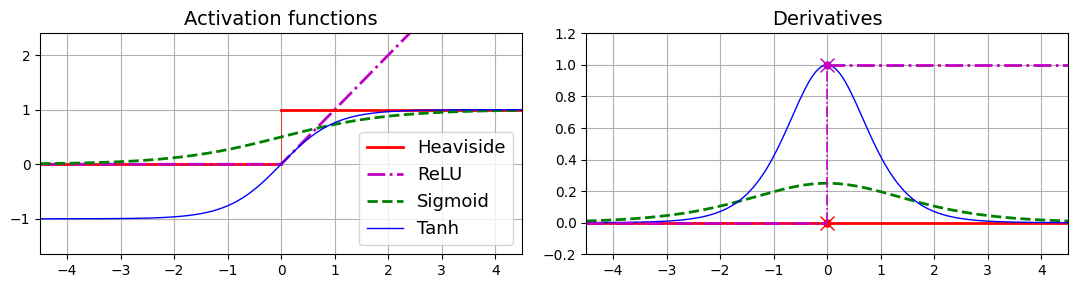

In [10]:
# extra code – this cell generates and saves Figure 10–8

from scipy.special import expit as sigmoid

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

max_z = 4.5
z = np.linspace(-max_z, max_z, 200)

plt.figure(figsize=(11, 3.1))

plt.subplot(121)
plt.plot([-max_z, 0], [0, 0], "r-", linewidth=2, label="Heaviside")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.plot([0, 0], [0, 1], "r-", linewidth=0.5)
plt.plot([0, max_z], [1, 1], "r-", linewidth=2)
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=1, label="Tanh")
plt.grid(True)
plt.title("Activation functions")
plt.axis([-max_z, max_z, -1.65, 2.4])
plt.gca().set_yticks([-1, 0, 1, 2])
plt.legend(loc="lower right", fontsize=13)

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=2, label="Heaviside")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=1, label="Tanh")
plt.plot([-max_z, 0], [0, 0], "m-.", linewidth=2)
plt.plot([0, max_z], [1, 1], "m-.", linewidth=2)
plt.plot([0, 0], [0, 1], "m-.", linewidth=1.2)
plt.plot(0, 1, "mo", markersize=5)
plt.plot(0, 1, "mx", markersize=10)
plt.grid(True)
plt.title("Derivatives")
plt.axis([-max_z, max_z, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

### Regression MLPs

In [12]:
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

mlp_reg = MLPRegressor(hidden_layer_sizes=[50, 50, 50], random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_reg)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_valid)
rmse = mean_squared_error(y_valid, y_pred, squared=False)

In [13]:
rmse

0.5053326657968797

### Classification MLPs

In [14]:
# extra code – this was left as an exercise for the reader

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

iris = load_iris()
X_train_full, X_test, y_train_full, y_test = train_test_split(iris.data, iris.target, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.1, random_state=42)

mlp_clf = MLPClassifier(hidden_layer_sizes=[5], max_iter=10_000, random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_clf)
pipeline.fit(X_train, y_train)
accuracy = pipeline.score(X_valid, y_valid)
accuracy

1.0

## Implementing MLPs with Keras

### Building an Image Classifier Using the Sequential API

#### Using Keras to load the dataset

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `tf.keras.datasets`. The dataset is already split for you between a training set (60,000 images) and a test set (10,000 images), but it can be useful to split the training set further to have a validation set. We'll use 55,000 images for training, and 5,000 for validation.

In [15]:
import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

The training set contains 60,000 grayscale images, each 28x28 pixels:

In [16]:
X_train.shape

(55000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [17]:
X_train.dtype

dtype('uint8')

Let's scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255:

In [18]:
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

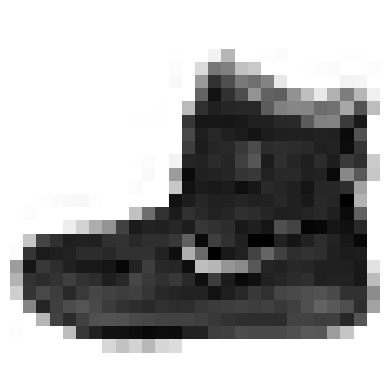

In [19]:
# extra code

plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [20]:
y_train

array([9, 0, 0, ..., 9, 0, 2], dtype=uint8)

Here are the corresponding class names:

In [21]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is an ankle boot:

In [22]:
class_names[y_train[0]]

'Ankle boot'

Let's take a look at a sample of the images in the dataset:

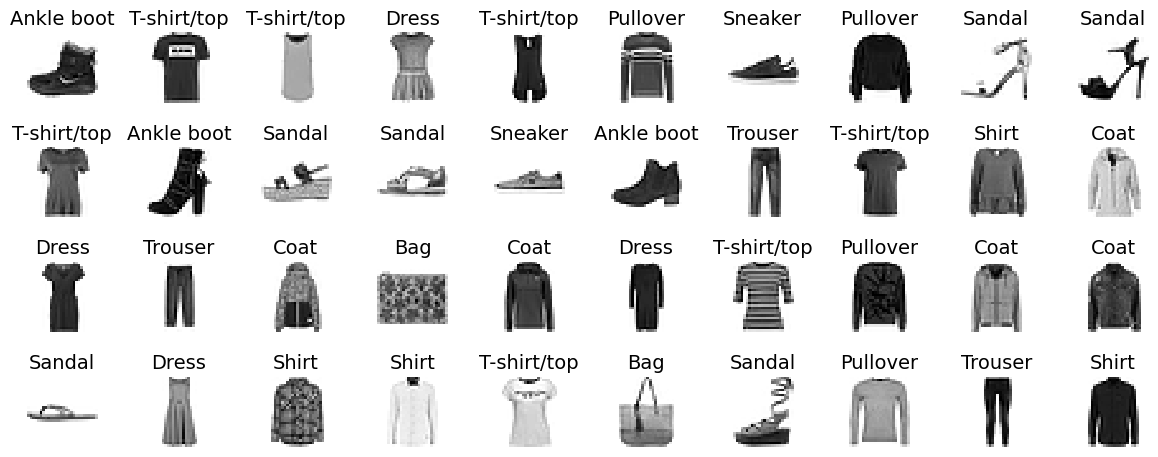

In [23]:
# extra code – this cell generates and saves Figure 10–10

n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)

save_fig("fashion_mnist_plot")
plt.show()

#### Creating the model using the Sequential API

In [24]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[28, 28]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(300, activation="relu"))
model.add(tf.keras.layers.Dense(100, activation="relu"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [25]:
# extra code – clear the session to reset the name counters
tf.keras.backend.clear_session()
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
# extra code – another way to display the model's architecture
tf.keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [30]:
model.layers

In [31]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [32]:
model.get_layer('dense') is hidden1

True

In [33]:
weights, biases = hidden1.get_weights()
weights

array([[-0.05243184, -0.05182834,  0.00681776, ..., -0.01648863,
        -0.0079356 ,  0.02272643],
       [-0.05554403, -0.0103886 , -0.03816878, ...,  0.03221986,
         0.06255387, -0.04660591],
       [ 0.02652515, -0.03344987,  0.059038  , ...,  0.04523557,
        -0.04099092, -0.06830242],
       ...,
       [-0.00350754,  0.00552523,  0.00624403, ..., -0.0248521 ,
         0.03857735,  0.05089845],
       [ 0.00955682, -0.05535261, -0.01637174, ...,  0.05081047,
         0.00926798,  0.06847866],
       [-0.05194589,  0.04884636, -0.07020088, ...,  0.05613142,
         0.01262055, -0.00098906]], dtype=float32)

In [34]:
weights.shape

(784, 300)

In [35]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [36]:
biases.shape

(300,)

#### Compiling the model

In [37]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

This is equivalent to:

In [38]:
# extra code – this cell is equivalent to the previous cell
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

In [39]:
# extra code – shows how to convert class ids to one-hot vectors
tf.keras.utils.to_categorical([0, 5, 1, 0], num_classes=10)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

Note: it's important to set `num_classes` when the number of classes is greater than the maximum class id in the sample.

In [40]:
# extra code – shows how to convert one-hot vectors to class ids
np.argmax(
    [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
     [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
     [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
    axis=1
)

array([0, 5, 1, 0])

#### Training and evaluating the model

In [41]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30


2023-12-26 19:52:08.601894: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 172480000 exceeds 10% of free system memory.


1719/1719 [==============================] - 6s 3ms/step - loss: 0.7184 - sparse_categorical_accuracy: 0.7649 - val_loss: 0.5071 - val_sparse_categorical_accuracy: 0.8250
Epoch 2/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4882 - sparse_categorical_accuracy: 0.8306 - val_loss: 0.4720 - val_sparse_categorical_accuracy: 0.8286
Epoch 3/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4402 - sparse_categorical_accuracy: 0.8451 - val_loss: 0.4266 - val_sparse_categorical_accuracy: 0.8496
Epoch 4/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4155 - sparse_categorical_accuracy: 0.8533 - val_loss: 0.3958 - val_sparse_categorical_accuracy: 0.8600
Epoch 5/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3955 - sparse_categorical_accuracy: 0.8614 - val_loss: 0.3872 - val_sparse_categorical_accuracy: 0.8586
Epoch 6/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3790 - sparse_categoric

In [42]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [43]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


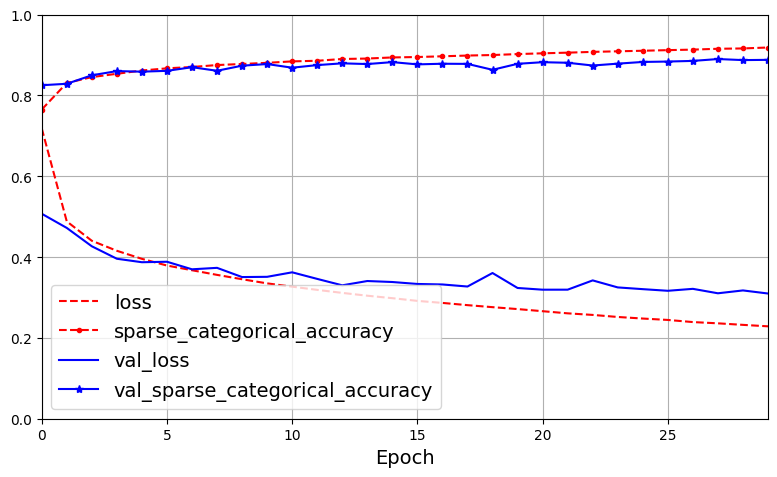

In [44]:
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")  # extra code
save_fig("keras_learning_curves_plot")  # extra code
plt.show()

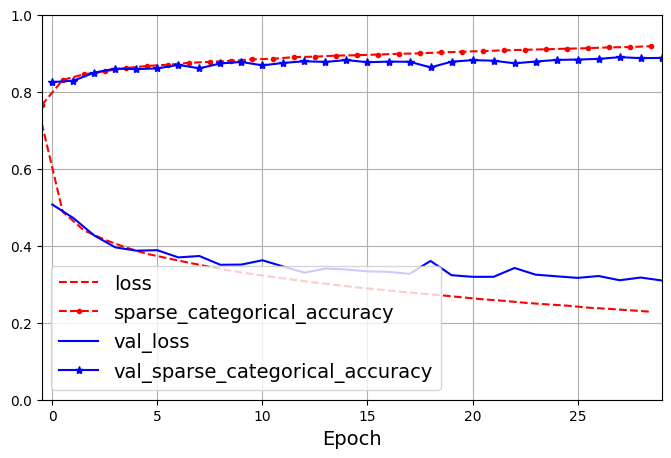

In [45]:
# extra code – shows how to shift the training curve by -1/2 epoch
plt.figure(figsize=(8, 5))
for key, style in zip(history.history, ["r--", "r--.", "b-", "b-*"]):
    epochs = np.array(history.epoch) + (0 if key.startswith("val_") else -0.5)
    plt.plot(epochs, history.history[key], style, label=key)
plt.xlabel("Epoch")
plt.axis([-0.5, 29, 0., 1])
plt.legend(loc="lower left")
plt.grid()
plt.show()

In [46]:
model.evaluate(X_test, y_test)

 54/313 [====>.........................] - ETA: 0s - loss: 0.3158 - sparse_categorical_accuracy: 0.8912

2023-12-26 19:58:00.031923: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.


313/313 [==============================] - 1s 2ms/step - loss: 0.3281 - sparse_categorical_accuracy: 0.8842


[0.3280753195285797, 0.8841999769210815]

#### Using the model to make predictions

In [47]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 106ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.97],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [48]:
y_pred = y_proba.argmax(axis=-1)
y_pred

array([9, 2, 1])

In [49]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [50]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

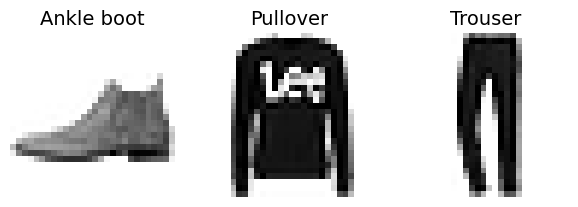

In [51]:
# extra code – this cell generates and saves Figure 10–12
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

### Building a Regression MLP Using the Sequential API

Let's load, split and scale the California housing dataset (the original one, not the modified one as in chapter 2):

In [52]:
# extra code – load and split the California housing dataset, like earlier
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

In [50]:
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
norm_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test, rmse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 0.9051 - root_mean_squared_error: 0.9514 - val_loss: 0.4030 - val_root_mean_squared_error: 0.6348
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3843 - root_mean_squared_error: 0.6199 - val_loss: 0.8436 - val_root_mean_squared_error: 0.9185
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3609 - root_mean_squared_error: 0.6007 - val_loss: 0.3744 - val_root_mean_squared_error: 0.6119
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3416 - root_mean_squared_error: 0.5844 - val_loss: 0.4343 - val_root_mean_squared_error: 0.6590
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3301 - root_mean_squared_error: 0.5746 - val_loss: 0.3085 - val_root_mean_squared_error: 0.5554
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3168 - root_mean_squared_error: 0.5629 - val_loss: 0.4544 - val_

In [51]:
rmse_test

0.5297096967697144

In [52]:
y_pred

array([[0.4969182],
       [1.195265 ],
       [4.9428763]], dtype=float32)

### Building Complex Models Using the Functional API

Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network (see [paper](https://ai.google/research/pubs/pub45413)) connects all or part of the inputs directly to the output layer.

In [53]:
# extra code – reset the name counters and make the code reproducible
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [54]:
normalization_layer = tf.keras.layers.Normalization()
hidden_layer1 = tf.keras.layers.Dense(30, activation="relu")
hidden_layer2 = tf.keras.layers.Dense(30, activation="relu")
concat_layer = tf.keras.layers.Concatenate()
output_layer = tf.keras.layers.Dense(1)

input_ = tf.keras.layers.Input(shape=X_train.shape[1:])
normalized = normalization_layer(input_)
hidden1 = hidden_layer1(normalized)
hidden2 = hidden_layer2(hidden1)
concat = concat_layer([normalized, hidden2])
output = output_layer(concat)

model = tf.keras.Model(inputs=[input_], outputs=[output])

In [55]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 normalization (Normalization)  (None, 8)            17          ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 30)           270         ['normalization[0][0]']          
                                                                                                  
 dense_1 (Dense)                (None, 30)           930         ['dense[0][0]']                  
                                                                                              

In [56]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
normalization_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 122.3226 - root_mean_squared_error: 11.0600 - val_loss: 305.9134 - val_root_mean_squared_error: 17.4904
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 5.5425 - root_mean_squared_error: 2.3543 - val_loss: 183.4622 - val_root_mean_squared_error: 13.5448
Epoch 3/20
363/363 [==============================] - 0s 979us/step - loss: 3.0631 - root_mean_squared_error: 1.7502 - val_loss: 87.2228 - val_root_mean_squared_error: 9.3393
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 1.5796 - root_mean_squared_error: 1.2568 - val_loss: 35.3699 - val_root_mean_squared_error: 5.9473
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.9536 - root_mean_squared_error: 0.9765 - val_loss: 12.3882 - val_root_mean_squared_error: 3.5197
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6322 - root_mean_squared_error: 0.7951 - val_loss:

What if you want to send different subsets of input features through the wide or deep paths? We will send 5 features (features 0 to 4), and 6 through the deep path (features 2 to 7). Note that 3 features will go through both (features 2, 3 and 4).

In [57]:
tf.random.set_seed(42)  # extra code

In [58]:
input_wide = tf.keras.layers.Input(shape=[5])  # features 0 to 4
input_deep = tf.keras.layers.Input(shape=[6])  # features 2 to 7
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
model = tf.keras.Model(inputs=[input_wide, input_deep], outputs=[output])

In [59]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])

X_train_wide, X_train_deep = X_train[:, :5], X_train[:, 2:]
X_valid_wide, X_valid_deep = X_valid[:, :5], X_valid[:, 2:]
X_test_wide, X_test_deep = X_test[:, :5], X_test[:, 2:]
X_new_wide, X_new_deep = X_test_wide[:3], X_test_deep[:3]

norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit((X_train_wide, X_train_deep), y_train, epochs=20,
                    validation_data=((X_valid_wide, X_valid_deep), y_valid))
mse_test = model.evaluate((X_test_wide, X_test_deep), y_test)
y_pred = model.predict((X_new_wide, X_new_deep))

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.2768 - root_mean_squared_error: 1.1300 - val_loss: 0.9497 - val_root_mean_squared_error: 0.9745
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4767 - root_mean_squared_error: 0.6904 - val_loss: 1.4311 - val_root_mean_squared_error: 1.1963
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4433 - root_mean_squared_error: 0.6658 - val_loss: 0.4258 - val_root_mean_squared_error: 0.6525
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4057 - root_mean_squared_error: 0.6370 - val_loss: 0.4016 - val_root_mean_squared_error: 0.6338
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3940 - root_mean_squared_error: 0.6277 - val_loss: 1.4914 - val_root_mean_squared_error: 1.2212
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3873 - root_mean_squared_error: 0.6224 - val_loss: 2.6759 - val_

Adding an auxiliary output for regularization:

In [60]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [61]:
input_wide = tf.keras.layers.Input(shape=[5])  # features 0 to 4
input_deep = tf.keras.layers.Input(shape=[6])  # features 2 to 7
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
aux_output = tf.keras.layers.Dense(1)(hidden2)
model = tf.keras.Model(inputs=[input_wide, input_deep],
                       outputs=[output, aux_output])

In [62]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss=("mse", "mse"), loss_weights=(0.9, 0.1), optimizer=optimizer,
              metrics=["RootMeanSquaredError"])

In [63]:
norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=20,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid))
)

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.3490 - dense_2_loss: 1.2742 - dense_3_loss: 2.0215 - dense_2_root_mean_squared_error: 1.1288 - dense_3_root_mean_squared_error: 1.4218 - val_loss: 1.5415 - val_dense_2_loss: 0.9593 - val_dense_3_loss: 6.7806 - val_dense_2_root_mean_squared_error: 0.9795 - val_dense_3_root_mean_squared_error: 2.6040
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5101 - dense_2_loss: 0.4785 - dense_3_loss: 0.7952 - dense_2_root_mean_squared_error: 0.6917 - dense_3_root_mean_squared_error: 0.8917 - val_loss: 1.3624 - val_dense_2_loss: 1.0094 - val_dense_3_loss: 4.5401 - val_dense_2_root_mean_squared_error: 1.0047 - val_dense_3_root_mean_squared_error: 2.1307
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4618 - dense_2_loss: 0.4404 - dense_3_loss: 0.6546 - dense_2_root_mean_squared_error: 0.6636 - dense_3_root_mean_squared_error: 0.8091 - val_loss: 0.5361 - val_dense_2_loss

In [64]:
eval_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test))
weighted_sum_of_losses, main_loss, aux_loss, main_rmse, aux_rmse = eval_results

162/162 [==============================] - 0s 778us/step - loss: 0.3446 - dense_2_loss: 0.3381 - dense_3_loss: 0.4031 - dense_2_root_mean_squared_error: 0.5815 - dense_3_root_mean_squared_error: 0.6349


In [65]:
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

In [66]:
y_pred_tuple = model.predict((X_new_wide, X_new_deep))
y_pred = dict(zip(model.output_names, y_pred_tuple))

### Using the Subclassing API to Build Dynamic Models

In [67]:
class WideAndDeepModel(tf.keras.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)  # needed to support naming the model
        self.norm_layer_wide = tf.keras.layers.Normalization()
        self.norm_layer_deep = tf.keras.layers.Normalization()
        self.hidden1 = tf.keras.layers.Dense(units, activation=activation)
        self.hidden2 = tf.keras.layers.Dense(units, activation=activation)
        self.main_output = tf.keras.layers.Dense(1)
        self.aux_output = tf.keras.layers.Dense(1)
        
    def call(self, inputs):
        input_wide, input_deep = inputs
        norm_wide = self.norm_layer_wide(input_wide)
        norm_deep = self.norm_layer_deep(input_deep)
        hidden1 = self.hidden1(norm_deep)
        hidden2 = self.hidden2(hidden1)
        concat = tf.keras.layers.concatenate([norm_wide, hidden2])
        output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return output, aux_output

tf.random.set_seed(42)  # extra code – just for reproducibility
model = WideAndDeepModel(30, activation="relu", name="my_cool_model")

In [68]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=optimizer,
              metrics=["RootMeanSquaredError"])
model.norm_layer_wide.adapt(X_train_wide)
model.norm_layer_deep.adapt(X_train_deep)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)))
eval_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test))
weighted_sum_of_losses, main_loss, aux_loss, main_rmse, aux_rmse = eval_results
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

Epoch 1/10
363/363 [==============================] - 1s 2ms/step - loss: 1.3490 - output_1_loss: 1.2742 - output_2_loss: 2.0215 - output_1_root_mean_squared_error: 1.1288 - output_2_root_mean_squared_error: 1.4218 - val_loss: 1.5415 - val_output_1_loss: 0.9593 - val_output_2_loss: 6.7806 - val_output_1_root_mean_squared_error: 0.9795 - val_output_2_root_mean_squared_error: 2.6040
Epoch 2/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5101 - output_1_loss: 0.4785 - output_2_loss: 0.7952 - output_1_root_mean_squared_error: 0.6917 - output_2_root_mean_squared_error: 0.8917 - val_loss: 1.3624 - val_output_1_loss: 1.0094 - val_output_2_loss: 4.5401 - val_output_1_root_mean_squared_error: 1.0047 - val_output_2_root_mean_squared_error: 2.1307
Epoch 3/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4618 - output_1_loss: 0.4404 - output_2_loss: 0.6546 - output_1_root_mean_squared_error: 0.6636 - output_2_root_mean_squared_error: 0.8091 - val_loss: 0.536

### Saving and Restoring a Model

In [69]:
# extra code – delete the directory, in case it already exists

import shutil

shutil.rmtree("my_keras_model", ignore_errors=True)

In [70]:
model.save("my_keras_model", save_format="tf")

INFO:tensorflow:Assets written to: my_keras_model/assets


In [71]:
# extra code – show the contents of the my_keras_model/ directory
for path in sorted(Path("my_keras_model").glob("**/*")):
    print(path)

my_keras_model/assets
my_keras_model/keras_metadata.pb
my_keras_model/saved_model.pb
my_keras_model/variables
my_keras_model/variables/variables.data-00000-of-00001
my_keras_model/variables/variables.index


In [72]:
model = tf.keras.models.load_model("my_keras_model")
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

In [73]:
model.save_weights("my_weights")

In [74]:
model.load_weights("my_weights")

In [75]:
# extra code – show the list of my_weights.* files
for path in sorted(Path().glob("my_weights.*")):
    print(path)

my_weights.data-00000-of-00001
my_weights.index


### Using Callbacks

In [76]:
shutil.rmtree("my_checkpoints", ignore_errors=True)  # extra code

In [77]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_checkpoints",
                                                   save_weights_only=True)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[checkpoint_cb])

Epoch 1/10
363/363 [==============================] - 1s 2ms/step - loss: 0.3775 - output_1_loss: 0.3706 - output_2_loss: 0.4402 - output_1_root_mean_squared_error: 0.6088 - output_2_root_mean_squared_error: 0.6635 - val_loss: 0.3369 - val_output_1_loss: 0.3234 - val_output_2_loss: 0.4587 - val_output_1_root_mean_squared_error: 0.5687 - val_output_2_root_mean_squared_error: 0.6773
Epoch 2/10
363/363 [==============================] - 1s 1ms/step - loss: 0.3556 - output_1_loss: 0.3480 - output_2_loss: 0.4242 - output_1_root_mean_squared_error: 0.5899 - output_2_root_mean_squared_error: 0.6513 - val_loss: 0.4940 - val_output_1_loss: 0.4650 - val_output_2_loss: 0.7551 - val_output_1_root_mean_squared_error: 0.6819 - val_output_2_root_mean_squared_error: 0.8689
Epoch 3/10
363/363 [==============================] - 1s 1ms/step - loss: 0.3612 - output_1_loss: 0.3547 - output_2_loss: 0.4198 - output_1_root_mean_squared_error: 0.5956 - output_2_root_mean_squared_error: 0.6480 - val_loss: 0.344

In [78]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=100,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
363/363 [==============================] - 1s 1ms/step - loss: 0.3405 - output_1_loss: 0.3349 - output_2_loss: 0.3910 - output_1_root_mean_squared_error: 0.5787 - output_2_root_mean_squared_error: 0.6253 - val_loss: 0.6245 - val_output_1_loss: 0.6502 - val_output_2_loss: 0.3937 - val_output_1_root_mean_squared_error: 0.8063 - val_output_2_root_mean_squared_error: 0.6275
Epoch 2/100
363/363 [==============================] - 1s 1ms/step - loss: 0.3400 - output_1_loss: 0.3344 - output_2_loss: 0.3900 - output_1_root_mean_squared_error: 0.5783 - output_2_root_mean_squared_error: 0.6245 - val_loss: 0.9552 - val_output_1_loss: 0.9508 - val_output_2_loss: 0.9947 - val_output_1_root_mean_squared_error: 0.9751 - val_output_2_root_mean_squared_error: 0.9974
Epoch 3/100
363/363 [==============================] - 1s 1ms/step - loss: 0.3442 - output_1_loss: 0.3389 - output_2_loss: 0.3921 - output_1_root_mean_squared_error: 0.5821 - output_2_root_mean_squared_error: 0.6262 - val_loss: 0.

In [79]:
class PrintValTrainRatioCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        ratio = logs["val_loss"] / logs["loss"]
        print(f"Epoch={epoch}, val/train={ratio:.2f}")

In [80]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[val_train_ratio_cb], verbose=0)

Epoch=0, val/train=2.29
Epoch=1, val/train=1.03
Epoch=2, val/train=2.07
Epoch=3, val/train=1.76
Epoch=4, val/train=3.56
Epoch=5, val/train=1.86
Epoch=6, val/train=2.45
Epoch=7, val/train=7.86
Epoch=8, val/train=11.20
Epoch=9, val/train=1.14


### Using TensorBoard for Visualization

TensorBoard is preinstalled on Colab, but not the `tensorboard-plugin-profile`, so let's install it:

In [81]:
if "google.colab" in sys.modules:  # extra code
    %pip install -q -U tensorboard-plugin-profile

In [82]:
shutil.rmtree("my_logs", ignore_errors=True)

In [83]:
from pathlib import Path
from time import strftime

def get_run_logdir(root_logdir="my_logs"):
    return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S")

run_logdir = get_run_logdir()

In [84]:
# extra code – builds the first regression model we used earlier
tf.keras.backend.clear_session()
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
norm_layer.adapt(X_train)

In [85]:
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir,
                                                profile_batch=(100, 200))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb])

2022-08-01 17:25:59.099970: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2022-08-01 17:25:59.099982: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2022-08-01 17:25:59.100137: I tensorflow/core/profiler/lib/profiler_session.cc:143] Profiler session tear down.


Epoch 1/20
261/363 [====================>.........] - ETA: 0s - loss: 2.3165 - root_mean_squared_error: 1.5220

2022-08-01 17:25:59.430946: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2022-08-01 17:25:59.430962: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2022-08-01 17:25:59.510100: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2022-08-01 17:25:59.524969: I tensorflow/core/profiler/lib/profiler_session.cc:143] Profiler session tear down.
2022-08-01 17:25:59.539451: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: my_logs/run_2022_08_01_17_25_59/plugins/profile/2022_08_01_17_26_00

2022-08-01 17:25:59.549606: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to my_logs/run_2022_08_01_17_25_59/plugins/profile/2022_08_01_17_26_00/my_computer.trace.json.gz
2022-08-01 17:25:59.558338: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: my_logs/run_2022_08_01_17_25_59/plug

363/363 [==============================] - 1s 1ms/step - loss: 1.8866 - root_mean_squared_error: 1.3736 - val_loss: 0.7126 - val_root_mean_squared_error: 0.8442
Epoch 2/20
363/363 [==============================] - 0s 907us/step - loss: 0.6577 - root_mean_squared_error: 0.8110 - val_loss: 0.6880 - val_root_mean_squared_error: 0.8295
Epoch 3/20
363/363 [==============================] - 0s 836us/step - loss: 0.5934 - root_mean_squared_error: 0.7703 - val_loss: 0.5803 - val_root_mean_squared_error: 0.7618
Epoch 4/20
363/363 [==============================] - 0s 832us/step - loss: 0.5557 - root_mean_squared_error: 0.7455 - val_loss: 0.5166 - val_root_mean_squared_error: 0.7188
Epoch 5/20
363/363 [==============================] - 0s 985us/step - loss: 0.5272 - root_mean_squared_error: 0.7261 - val_loss: 0.4895 - val_root_mean_squared_error: 0.6997
Epoch 6/20
363/363 [==============================] - 0s 887us/step - loss: 0.5033 - root_mean_squared_error: 0.7094 - val_loss: 0.4951 - val_r

In [86]:
print("my_logs")
for path in sorted(Path("my_logs").glob("**/*")):
    print("  " * (len(path.parts) - 1) + path.parts[-1])

my_logs
  run_2022_08_01_17_25_59
    events.out.tfevents.1638910166.my_computer.profile-empty
    plugins
      profile
        2022_08_01_17_26_00
          my_computer.input_pipeline.pb
          my_computer.kernel_stats.pb
          my_computer.memory_profile.json.gz
          my_computer.overview_page.pb
          my_computer.tensorflow_stats.pb
          my_computer.trace.json.gz
          my_computer.xplane.pb
    train
      events.out.tfevents.1638910166.my_computer.22294.0.v2
    validation
      events.out.tfevents.1638910166.my_computer.22294.1.v2


Let's load the `tensorboard` Jupyter extension and start the TensorBoard server: 

In [87]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs

**Note**: if you prefer to access TensorBoard in a separate tab, click the "localhost:6006" link below:

In [88]:
# extra code

if "google.colab" in sys.modules:
    from google.colab import output

    output.serve_kernel_port_as_window(6006)
else:
    from IPython.display import display, HTML

    display(HTML('<a href="http://localhost:6006/">http://localhost:6006/</a>'))

You can use also visualize histograms, images, text, and even listen to audio using TensorBoard:

In [89]:
test_logdir = get_run_logdir()
writer = tf.summary.create_file_writer(str(test_logdir))
with writer.as_default():
    for step in range(1, 1000 + 1):
        tf.summary.scalar("my_scalar", np.sin(step / 10), step=step)
        
        data = (np.random.randn(100) + 2) * step / 100  # gets larger
        tf.summary.histogram("my_hist", data, buckets=50, step=step)
        
        images = np.random.rand(2, 32, 32, 3) * step / 1000  # gets brighter
        tf.summary.image("my_images", images, step=step)
        
        texts = ["The step is " + str(step), "Its square is " + str(step ** 2)]
        tf.summary.text("my_text", texts, step=step)
        
        sine_wave = tf.math.sin(tf.range(12000) / 48000 * 2 * np.pi * step)
        audio = tf.reshape(tf.cast(sine_wave, tf.float32), [1, -1, 1])
        tf.summary.audio("my_audio", audio, sample_rate=48000, step=step)

You can share your TensorBoard logs with the world by uploading them to https://tensorboard.dev/. For this, you can run the `tensorboard dev upload` command, with the `--logdir` and `--one_shot` options, and optionally the `--name` and `--description` options. The first time, it will ask you to accept Google's Terms of Service, and to authenticate.

Notes:
* Authenticating requires user input. Colab supports user input from shell commands, but the main other Jupyter environments do not, so for them we use a hackish workaround (alternatively, you could run the command in a terminal window, after you make sure to activate this project's conda environment and move to this notebook's directory).
* If you get an authentication related error (such as *invalid_grant: Bad Request*), it's likely that your login session has expired. In this case, try running the command `tensorboard dev auth revoke` to logout, and try again.

In [90]:
# extra code

if "google.colab" in sys.modules:
    !tensorboard dev upload --logdir ./my_logs --one_shot \
                            --name "Quick test" --description "This is a test" 
else:
    from tensorboard.main import run_main

    argv = "tensorboard dev upload --logdir ./my_logs --one_shot".split()
    argv += ["--name", "Quick test", "--description", "This is a test"]
    try:
        original_sys_argv_and_sys_exit = sys.argv, sys.exit
        sys.argv, sys.exit = argv, lambda status: None
        run_main()
    finally:
        sys.argv, sys.exit = original_sys_argv_and_sys_exit


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/il3YO6KgQHeQuMpX8cxgYw/

[2022-08-01T17:26:19] Started scanning logdir.
[2022-08-01T17:26:25] Total uploaded: 1120 scalars, 2000 tensors (1.2 MB), 1 binary objects (29.2 kB)
[2022-08-01T17:26:25] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/il3YO6KgQHeQuMpX8cxgYw/


You can get list your published experiments:

In [91]:
!tensorboard dev list

https://tensorboard.dev/experiment/il3YO6KgQHeQuMpX8cxgYw/
	Name                 Quick test
	Description          This is a test
	Id                   il3YO6KgQHeQuMpX8cxgYw
	Created              2022-08-01 17:26:19 (20 seconds ago)
	Updated              2022-08-01 17:26:25 (14 seconds ago)
	Runs                 3
	Tags                 8
	Scalars              1120
	Tensor bytes         1421436
	Binary object bytes  30096
Total: 1 experiment(s)


To delete an experiment, use the following command:

```python
!tensorboard dev delete --experiment_id <experiment_id>
```

When you stop this Jupyter kernel (a.k.a. Runtime), it will automatically stop the TensorBoard server as well. Another way to stop the TensorBoard server is to kill it, if you are running on Linux or MacOSX. First, you need to find its process ID:

In [92]:
# extra code – lists all running TensorBoard server instances

from tensorboard import notebook

notebook.list()

Known TensorBoard instances:
  - port 6006: logdir ./my_logs (started 0:00:31 ago; pid 22701)


Next you can use the following command on Linux or MacOSX, replacing `<pid>` with the pid listed above:

    !kill <pid>

On Windows:

    !taskkill /F /PID <pid>

## Fine-Tuning Neural Network Hyperparameters

In this section we'll use the Fashion MNIST dataset again:

In [93]:
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

In [94]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [95]:
if "google.colab" in sys.modules:
    %pip install -q -U keras_tuner

In [96]:
import keras_tuner as kt

def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model

In [97]:
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=5, overwrite=True,
    directory="my_fashion_mnist", project_name="my_rnd_search", seed=42)
random_search_tuner.search(X_train, y_train, epochs=10,
                           validation_data=(X_valid, y_valid))

Trial 5 Complete [00h 00m 24s]
val_accuracy: 0.8736000061035156

Best val_accuracy So Far: 0.8736000061035156
Total elapsed time: 00h 01m 43s
INFO:tensorflow:Oracle triggered exit


I1208 09:51:50.359315 4451454400 1158129808.py:4] Oracle triggered exit


In [98]:
top3_models = random_search_tuner.get_best_models(num_models=3)
best_model = top3_models[0]

In [99]:
top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
top3_params[0].values  # best hyperparameter values

{'n_hidden': 5,
 'n_neurons': 70,
 'learning_rate': 0.00041268008323824807,
 'optimizer': 'adam'}

In [100]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial summary
Hyperparameters:
n_hidden: 5
n_neurons: 70
learning_rate: 0.00041268008323824807
optimizer: adam
Score: 0.8736000061035156


In [101]:
best_trial.metrics.get_last_value("val_accuracy")

0.8736000061035156

In [102]:
best_model.fit(X_train_full, y_train_full, epochs=10)
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3274 - accuracy: 0.8799
Epoch 2/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3155 - accuracy: 0.8827
Epoch 3/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3049 - accuracy: 0.8867
Epoch 4/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2962 - accuracy: 0.8914
Epoch 5/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2886 - accuracy: 0.8931
Epoch 6/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2831 - accuracy: 0.8935
Epoch 7/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2795 - accuracy: 0.8962
Epoch 8/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2701 - accuracy: 0.8999: 0s - loss: 0
Epoch 9/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2661 - accuracy: 0.9009
Epoch 10/10
313/313 [==============================] - 0s 744us/step

In [103]:
class MyClassificationHyperModel(kt.HyperModel):
    def build(self, hp):
        return build_model(hp)

    def fit(self, hp, model, X, y, **kwargs):
        if hp.Boolean("normalize"):
            norm_layer = tf.keras.layers.Normalization()
            X = norm_layer(X)
        return model.fit(X, y, **kwargs)

In [104]:
hyperband_tuner = kt.Hyperband(
    MyClassificationHyperModel(), objective="val_accuracy", seed=42,
    max_epochs=10, factor=3, hyperband_iterations=2,
    overwrite=True, directory="my_fashion_mnist", project_name="hyperband")

In [105]:
root_logdir = Path(hyperband_tuner.project_dir) / "tensorboard"
tensorboard_cb = tf.keras.callbacks.TensorBoard(root_logdir)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2)
hyperband_tuner.search(X_train, y_train, epochs=10,
                       validation_data=(X_valid, y_valid),
                       callbacks=[early_stopping_cb, tensorboard_cb])

Trial 60 Complete [00h 00m 18s]
val_accuracy: 0.819599986076355

Best val_accuracy So Far: 0.8704000115394592
Total elapsed time: 00h 08m 44s
INFO:tensorflow:Oracle triggered exit


I1208 10:00:59.856360 4451454400 3169670597.py:4] Oracle triggered exit


In [106]:
bayesian_opt_tuner = kt.BayesianOptimization(
    MyClassificationHyperModel(), objective="val_accuracy", seed=42,
    max_trials=10, alpha=1e-4, beta=2.6,
    overwrite=True, directory="my_fashion_mnist", project_name="bayesian_opt")
bayesian_opt_tuner.search(X_train, y_train, epochs=10,
                          validation_data=(X_valid, y_valid),
                          callbacks=[early_stopping_cb])

Trial 10 Complete [00h 00m 13s]
val_accuracy: 0.7228000164031982

Best val_accuracy So Far: 0.8636000156402588
Total elapsed time: 00h 02m 10s
INFO:tensorflow:Oracle triggered exit


I1208 10:03:10.004801 4451454400 1918178380.py:5] Oracle triggered exit


In [107]:
%tensorboard --logdir {root_logdir}